### Hyporheic Averaging Based on Turbidity Threshold

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import linregress

# import the data, and make first column the index 
sp_sample_SSC = pd.read_csv('spring_SSC_turbidity_SAMPLES.csv', index_col=0, parse_dates=True)
sm_sample_SSC = pd.read_csv('summer_SSC_turbidity_SAMPLES.csv', index_col=0, parse_dates=True)
sp_SSC = pd.read_csv('spring_SSC_turbidity.csv', index_col=0, parse_dates=True)
sm_SSC = pd.read_csv('summer_SSC_turbidity.csv', index_col=0, parse_dates=True)

# drop nan values 
sp_sample_SSC = sp_sample_SSC.dropna()
sm_sample_SSC = sm_sample_SSC.dropna()
sp_SSC = sp_SSC.dropna()
sm_SSC = sm_SSC.dropna()

# fixing some weird things in the summer data
sm_SSC = sm_SSC[~sm_SSC.index.duplicated(keep='first')]
sm_SSC = sm_SSC.sort_index()

# resample the data to 1 minute intervals and interpolate
sp_SSC = sp_SSC.resample('1T').interpolate()
sm_SSC = sm_SSC.resample('1T').interpolate()

#### Scatter Plots

Spring

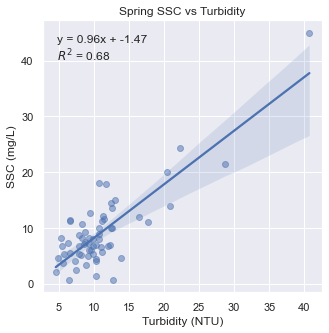

In [2]:
# calculate regression stats
x = sp_sample_SSC['Turbidity (FNU)']
y = sp_sample_SSC['SSC (mg/L)']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# scatter plot of SSC vs turbidity
sns.set(style="darkgrid") 
plt.figure(figsize=(5, 5))
sns.regplot(data=sp_sample_SSC, x='Turbidity (FNU)', y='SSC (mg/L)', 
        scatter_kws={'label': 'Spring', 'alpha': 0.5},)
# add regression equation and R² to the plot
eq_text = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}"
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)
plt.title('Spring SSC vs Turbidity')
plt.xlabel('Turbidity (NTU)')
plt.ylabel('SSC (mg/L)')
plt.show()


Summer

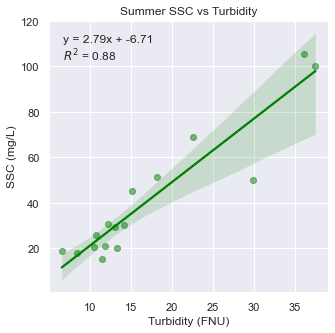

In [3]:
# calculate regression stats
x = sm_sample_SSC['Turbidity (FNU)']
y = sm_sample_SSC['SSC (mg/L)']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# scatter plot of SSC vs turbidity
sns.set(style="darkgrid") 
plt.figure(figsize=(5, 5))
sns.regplot(data=sm_sample_SSC, x='Turbidity (FNU)', y='SSC (mg/L)', 
        scatter_kws={'label': 'Spring', 'alpha': 0.5}, color='green',
        line_kws={'label': 'Spring', 'color': 'green'},)
# add regression equation and R² to the plot
eq_text = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}"
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)
plt.title('Summer SSC vs Turbidity')
plt.xlabel('Turbidity (FNU)')
plt.ylabel('SSC (mg/L)')
plt.show()

Note: cannot combine for a total rating curve, because turbidity units are different between seasons (FNU vs NTU)

#### Time Series

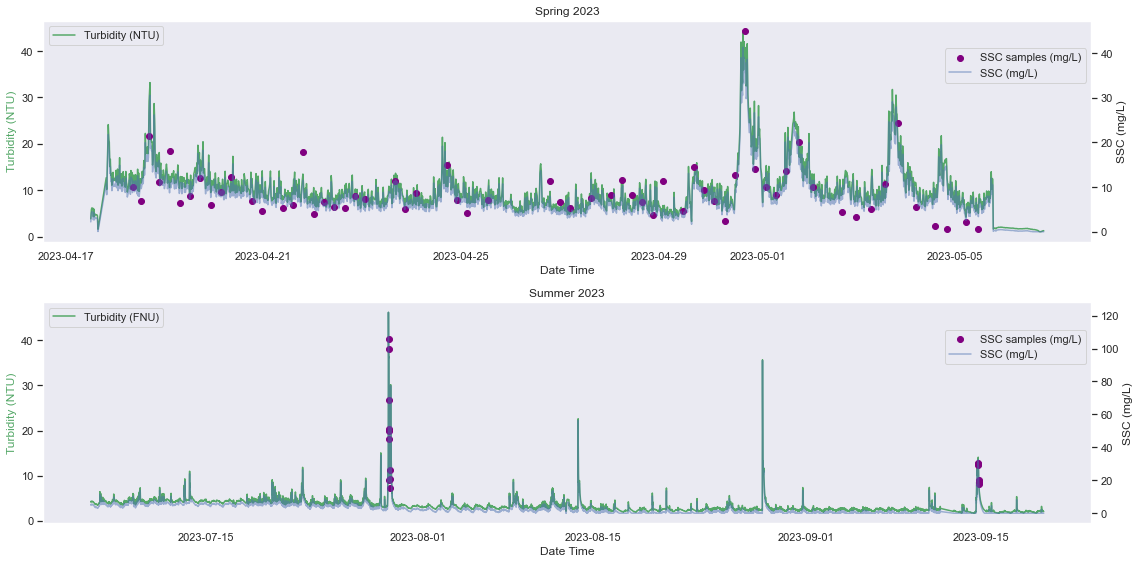

In [4]:
# plot turbidity and SSC concentration time series for both seasons 
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.scatter(sp_sample_SSC.index, sp_sample_SSC['SSC (mg/L)'], c='purple', marker='o', label='SSC samples (mg/L)')
ax2.plot(sp_SSC.index, sp_SSC['SSC (mg/L)'], label='SSC (mg/L)', alpha=0.5)


ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[0].set_title('Spring 2023')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.scatter(sm_sample_SSC.index, sm_sample_SSC['SSC (mg/L)'], c='purple', marker='o', label='SSC samples (mg/L)')
ax2.plot(sm_SSC.index, sm_SSC['SSC (mg/L)'], label='SSC (mg/L)', alpha=0.5)


ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

### Calculating Turbidity Threshold

#### Percentile threshold 

Functions

In [5]:
def merge_Q_turb(df_Q: pd.DataFrame, df_T: pd.DataFrame, q_col_name: str, turb_col_name: str, how: str = "inner",):
    # checking if the columns exist in the dataframes
    if q_col_name not in df_Q.columns:
        raise KeyError(f"'{q_col_name}' not found in df_Q columns")
    if turb_col_name not in df_T.columns:
        raise KeyError(f"'{turb_col_name}' not found in df_T columns")
    # merging the dataframes
    merged = (df_Q[[q_col_name]].merge(df_T[[turb_col_name]], left_index=True, right_index=True, how=how))
    return merged

def q_cutoff_from_baseflow(merged_df: pd.DataFrame, q_col: str, baseflow_quantile: float = 0.50,): 
    # filtering the merged dataframe to get the baseflow values
    return merged_df[q_col].quantile(baseflow_quantile)

def turbidity_threshold(merged_df: pd.DataFrame, Q_cutoff: float, q_col: str, turb_col: str, percentile: float = 99.0,):
    # filtering the turbidity values based on the Q cutoff
    base_turb = merged_df.loc[merged_df[q_col] <= Q_cutoff, turb_col].dropna() 
    # calculating the percentile of the filtered turbidity values
    return np.percentile(base_turb, percentile)

Importing Discahrge Data

In [6]:
# import the discharge data
q = pd.read_csv('../../Shear Stress/stress_partitioning/discharge_2023.csv', index_col=0, parse_dates=True)

# separate the spring and summer data
q_sp = q.loc['2023-04-01':'2023-06-01']
q_sm = q.loc['2023-07-01':'2023-09-17']

Spring 

In [7]:
# merge the spring q data with the spring turbidity data
merged_df = merge_Q_turb(q_sp, sp_SSC, q_col_name="Q", turb_col_name="Turbidity (NTU)", how="inner")

# compute Q cutoff
Q_cutoff = q_cutoff_from_baseflow(merged_df, q_col="Q", baseflow_quantile=0.50)
print(f"50th percentile of Q, which will be Q cutoff: {Q_cutoff:.2f} m3/s")

# compute critical turbidity
turb_crit = turbidity_threshold(merged_df, Q_cutoff, q_col="Q", turb_col="Turbidity (NTU)", percentile=99.0)
print(f"99th percentile of turbidity at Q cutoff: {turb_crit:.2f} NTU")

50th percentile of Q, which will be Q cutoff: 0.18 m3/s
99th percentile of turbidity at Q cutoff: 14.13 NTU


Summer

In [8]:
# merge the spring q data with the spring turbidity data
merged_df = merge_Q_turb(q_sm, sm_SSC, q_col_name="Q", turb_col_name="Turbidity (FNU)", how="inner")

# compute Q cutoff
Q_cutoff = q_cutoff_from_baseflow(merged_df, q_col="Q", baseflow_quantile=0.50)
print(f"50th percentile of Q, which will be Q cutoff: {Q_cutoff:.2f} m3/s")

# compute critical turbidity
turb_crit = turbidity_threshold(merged_df, Q_cutoff, q_col="Q", turb_col="Turbidity (FNU)", percentile=99.0)
print(f"99th percentile of turbidity at Q cutoff: {turb_crit:.2f} NTU")

50th percentile of Q, which will be Q cutoff: 0.01 m3/s
99th percentile of turbidity at Q cutoff: 5.01 NTU


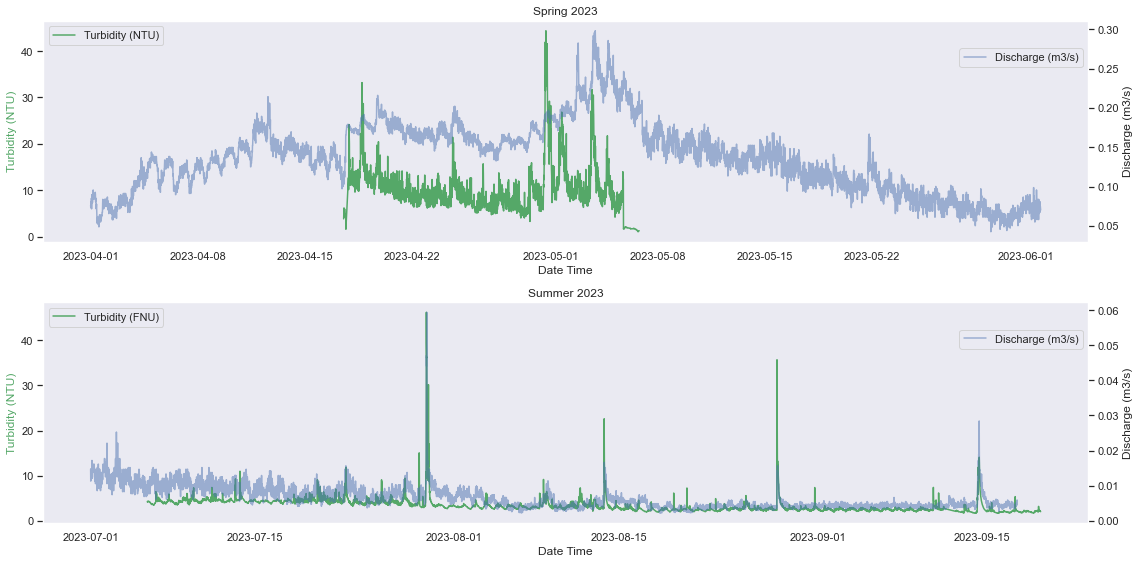

In [49]:
# plot turbidity and SSC concentration time series for both seasons 
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.plot(q_sp.index, q_sp['Q'], label='Discharge (m3/s)', alpha=0.5)


ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[0].set_title('Spring 2023')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.plot(q_sm.index, q_sm['Q'], label='Discharge (m3/s)', alpha=0.5)

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

### Plotting Different Threshold Methods

Percentile Threshold 

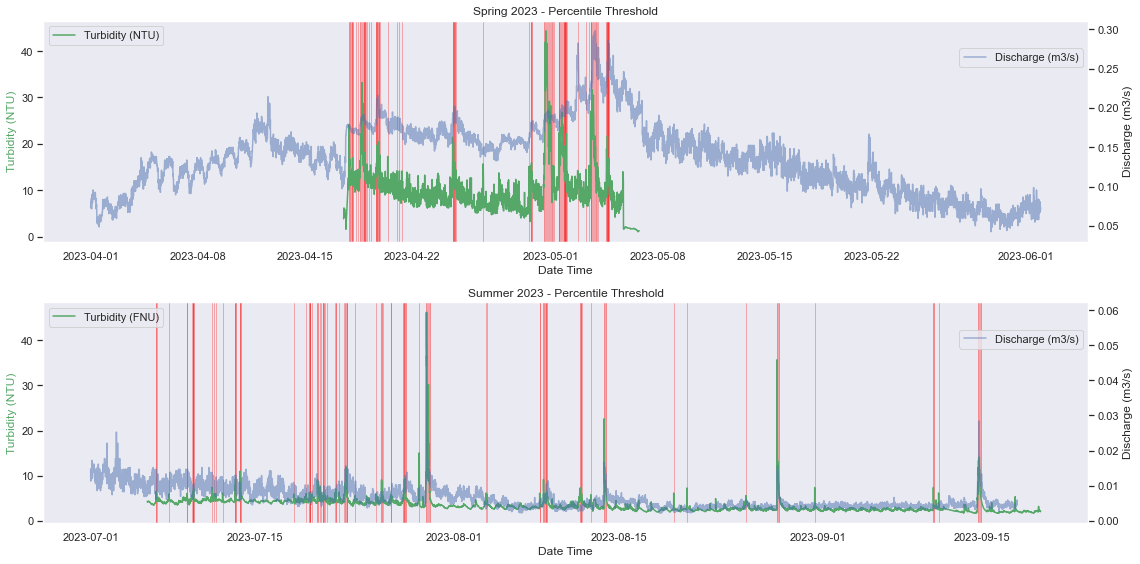

In [65]:
# input the turbidity threshold
spring_threshold = 14.13
summer_threshold = 5.55   

fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

### SPRING ###
ax2 = ax1[0].twinx()
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.plot(q_sp.index, q_sp['Q'], label='Discharge (m3/s)', alpha=0.5)

# find spring exceedance regions
spring_exceeds = sp_SSC['Turbidity (NTU)'] > spring_threshold
spring_regions = []
in_event = False
for i in range(len(spring_exceeds)):
    if spring_exceeds.iloc[i] and not in_event:
        start = sp_SSC.index[i]
        in_event = True
    elif not spring_exceeds.iloc[i] and in_event:
        end = sp_SSC.index[i]
        spring_regions.append((start, end))
        in_event = False
if in_event:
    spring_regions.append((start, sp_SSC.index[-1]))

# highlight spring exceedance periods
for start, end in spring_regions:
    ax1[0].axvspan(start, end, color='red', alpha=0.3)

ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[0].set_title('Spring 2023 - Percentile Threshold')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[0].grid(False)
ax2.grid(False)

### SUMMER ###
ax2 = ax1[1].twinx()
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.plot(q_sm.index, q_sm['Q'], label='Discharge (m3/s)', alpha=0.5)

# find summer exceedance regions
summer_exceeds = sm_SSC['Turbidity (FNU)'] > summer_threshold
summer_regions = []
in_event = False
for i in range(len(summer_exceeds)):
    if summer_exceeds.iloc[i] and not in_event:
        start = sm_SSC.index[i]
        in_event = True
    elif not summer_exceeds.iloc[i] and in_event:
        end = sm_SSC.index[i]
        summer_regions.append((start, end))
        in_event = False
if in_event:
    summer_regions.append((start, sm_SSC.index[-1]))

# highlight summer exceedance periods
for start, end in summer_regions:
    ax1[1].axvspan(start, end, color='red', alpha=0.3)

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[1].set_title('Summer 2023 - Percentile Threshold')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

SSC Rating Curve Threshold

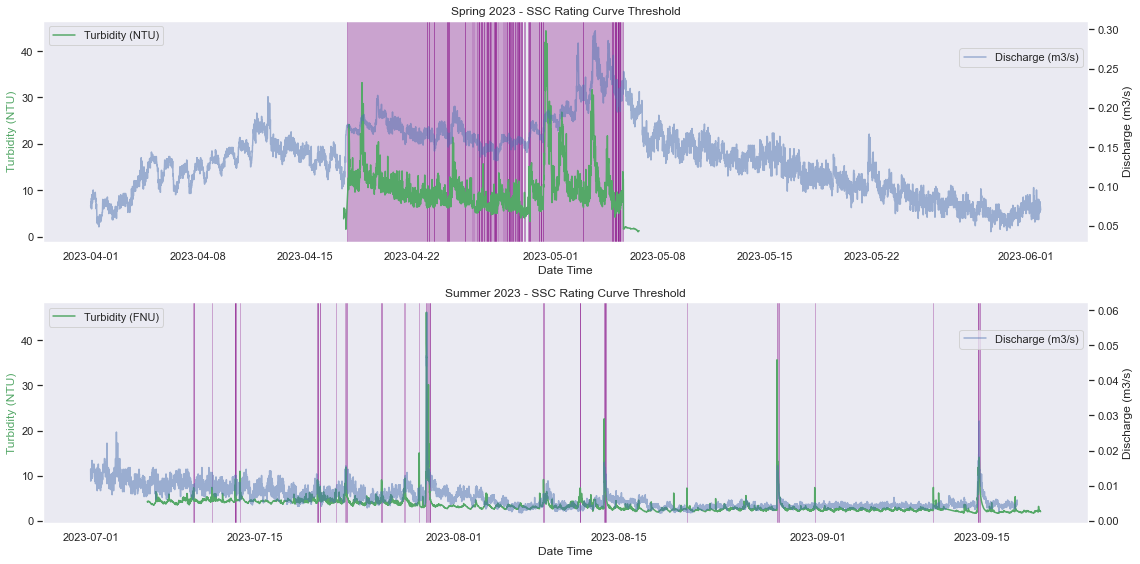

In [66]:
# input the turbidity threshold
spring_threshold = 6.340
summer_threshold = 6.55

fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

### SPRING ###
ax2 = ax1[0].twinx()
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.plot(q_sp.index, q_sp['Q'], label='Discharge (m3/s)', alpha=0.5)

# find spring exceedance regions
spring_exceeds = sp_SSC['Turbidity (NTU)'] > spring_threshold
spring_regions = []
in_event = False
for i in range(len(spring_exceeds)):
    if spring_exceeds.iloc[i] and not in_event:
        start = sp_SSC.index[i]
        in_event = True
    elif not spring_exceeds.iloc[i] and in_event:
        end = sp_SSC.index[i]
        spring_regions.append((start, end))
        in_event = False
if in_event:
    spring_regions.append((start, sp_SSC.index[-1]))

# highlight spring exceedance periods
for start, end in spring_regions:
    ax1[0].axvspan(start, end, color='purple', alpha=0.3)

ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[0].set_title('Spring 2023 - SSC Rating Curve Threshold')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[0].grid(False)
ax2.grid(False)

### SUMMER ###
ax2 = ax1[1].twinx()
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.plot(q_sm.index, q_sm['Q'], label='Discharge (m3/s)', alpha=0.5)

# find summer exceedance regions
summer_exceeds = sm_SSC['Turbidity (FNU)'] > summer_threshold
summer_regions = []
in_event = False
for i in range(len(summer_exceeds)):
    if summer_exceeds.iloc[i] and not in_event:
        start = sm_SSC.index[i]
        in_event = True
    elif not summer_exceeds.iloc[i] and in_event:
        end = sm_SSC.index[i]
        summer_regions.append((start, end))
        in_event = False
if in_event:
    summer_regions.append((start, sm_SSC.index[-1]))

# highlight summer exceedance periods
for start, end in summer_regions:
    ax1[1].axvspan(start, end, color='purple', alpha=0.3)

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[1].set_title('Summer 2023 - SSC Rating Curve Threshold')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

Sample Concentration Threshold

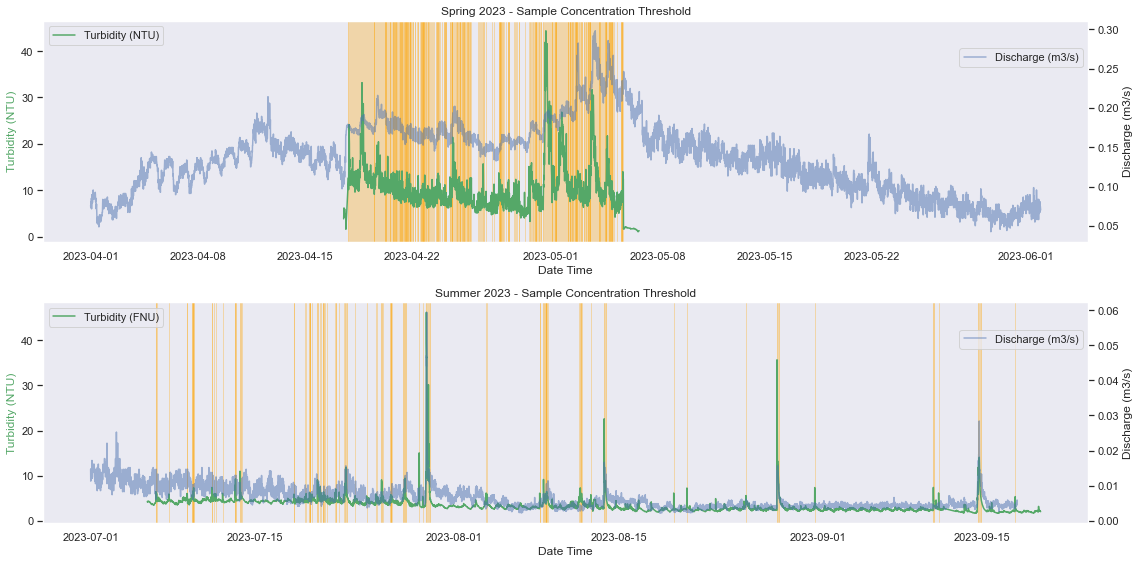

In [67]:
# input the turbidity threshold
spring_threshold = 9.33
summer_threshold = 5.35

fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

### SPRING ###
ax2 = ax1[0].twinx()
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.plot(q_sp.index, q_sp['Q'], label='Discharge (m3/s)', alpha=0.5)

# find spring exceedance regions
spring_exceeds = sp_SSC['Turbidity (NTU)'] > spring_threshold
spring_regions = []
in_event = False
for i in range(len(spring_exceeds)):
    if spring_exceeds.iloc[i] and not in_event:
        start = sp_SSC.index[i]
        in_event = True
    elif not spring_exceeds.iloc[i] and in_event:
        end = sp_SSC.index[i]
        spring_regions.append((start, end))
        in_event = False
if in_event:
    spring_regions.append((start, sp_SSC.index[-1]))

# highlight spring exceedance periods
for start, end in spring_regions:
    ax1[0].axvspan(start, end, color='orange', alpha=0.3)

ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[0].set_title('Spring 2023 - Sample Concentration Threshold')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[0].grid(False)
ax2.grid(False)

### SUMMER ###
ax2 = ax1[1].twinx()
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.plot(q_sm.index, q_sm['Q'], label='Discharge (m3/s)', alpha=0.5)

# find summer exceedance regions
summer_exceeds = sm_SSC['Turbidity (FNU)'] > summer_threshold
summer_regions = []
in_event = False
for i in range(len(summer_exceeds)):
    if summer_exceeds.iloc[i] and not in_event:
        start = sm_SSC.index[i]
        in_event = True
    elif not summer_exceeds.iloc[i] and in_event:
        end = sm_SSC.index[i]
        summer_regions.append((start, end))
        in_event = False
if in_event:
    summer_regions.append((start, sm_SSC.index[-1]))

# highlight summer exceedance periods
for start, end in summer_regions:
    ax1[1].axvspan(start, end, color='orange', alpha=0.3)

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('Discharge (m3/s)')
ax1[1].set_title('Summer 2023 - Sample Concentration Threshold')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

### Getting Exceedance Periods

In [68]:
def get_exceedance_periods(df, turb_col, threshold, season_label):
    exceedances = df[turb_col] > threshold
    periods = []
    in_event = False
    for i in range(len(exceedances)):
        if exceedances.iloc[i] and not in_event:
            start = df.index[i]
            in_event = True
        elif not exceedances.iloc[i] and in_event:
            end = df.index[i]
            periods.append((season_label, start, end))
            in_event = False
    if in_event:
        periods.append((season_label, start, df.index[-1]))
    return periods

Percentile Threshold

In [69]:
# get periods for spring and summer
spring_threshold = 14.13
summer_threshold = 5.55

spring_periods = get_exceedance_periods(sp_SSC, 'Turbidity (NTU)', spring_threshold, 'spring')
summer_periods = get_exceedance_periods(sm_SSC, 'Turbidity (FNU)', summer_threshold, 'summer')
# combine and export
all_periods = spring_periods + summer_periods
df_periods = pd.DataFrame(all_periods, columns=['season', 'start', 'end'])
percentile_periods = df_periods.copy()

# print the result
print(df_periods)
# export to CSV
df_periods.to_csv('exceedance_periods/turb_exceedance_percentile.csv', index=False)

# calculate total exceedance time
df_periods['start'] = pd.to_datetime(df_periods['start'])
df_periods['end'] = pd.to_datetime(df_periods['end'])
# calculate duration for each row
df_periods['duration'] = df_periods['end'] - df_periods['start']
# group by season and sum durations
duration_by_season = df_periods.groupby('season')['duration'].sum()
# convert to minutes
duration_minutes = duration_by_season.apply(lambda x: x.total_seconds() / 60)
# print result
for season, minutes in duration_minutes.items():
    print(f"Total exceedance time in {season}: {minutes:.2f} minutes")


     season               start                 end
0    spring 2023-04-17 20:13:00 2023-04-17 21:55:00
1    spring 2023-04-18 00:29:00 2023-04-18 00:30:00
2    spring 2023-04-18 01:12:00 2023-04-18 01:16:00
3    spring 2023-04-18 02:04:00 2023-04-18 02:22:00
4    spring 2023-04-18 07:44:00 2023-04-18 07:46:00
..      ...                 ...                 ...
119  summer 2023-08-28 12:03:00 2023-08-28 16:54:00
120  summer 2023-08-31 17:24:00 2023-08-31 17:53:00
121  summer 2023-09-10 19:49:00 2023-09-10 20:32:00
122  summer 2023-09-11 06:57:00 2023-09-11 07:06:00
123  summer 2023-09-14 14:43:00 2023-09-14 20:50:00

[124 rows x 3 columns]
Total exceedance time in spring: 3264.00 minutes
Total exceedance time in summer: 3499.00 minutes


SSC Rating Curve Threshold

In [70]:
# get periods for spring and summer
spring_threshold = 9.34
summer_threshold = 6.55

spring_periods = get_exceedance_periods(sp_SSC, 'Turbidity (NTU)', spring_threshold, 'spring')
summer_periods = get_exceedance_periods(sm_SSC, 'Turbidity (FNU)', summer_threshold, 'summer')
# combine and export
all_periods = spring_periods + summer_periods
df_periods = pd.DataFrame(all_periods, columns=['season', 'start', 'end'])
rating_curve_periods = df_periods.copy()

# print the result
print(df_periods)
# export to CSV
df_periods.to_csv('exceedance_periods/turb_exceedance_ratingcurve.csv', index=False)

# calculate total exceedance time
df_periods['start'] = pd.to_datetime(df_periods['start'])
df_periods['end'] = pd.to_datetime(df_periods['end'])
# calculate duration for each row
df_periods['duration'] = df_periods['end'] - df_periods['start']
# group by season and sum durations
duration_by_season = df_periods.groupby('season')['duration'].sum()
# convert to minutes
duration_minutes = duration_by_season.apply(lambda x: x.total_seconds() / 60)
# print result
for season, minutes in duration_minutes.items():
    print(f"Total exceedance time in {season}: {minutes:.2f} minutes")


     season               start                 end
0    spring 2023-04-17 18:32:00 2023-04-19 12:13:00
1    spring 2023-04-19 12:17:00 2023-04-20 04:42:00
2    spring 2023-04-20 05:02:00 2023-04-20 05:57:00
3    spring 2023-04-20 06:00:00 2023-04-20 13:14:00
4    spring 2023-04-20 13:15:00 2023-04-20 17:24:00
..      ...                 ...                 ...
214  summer 2023-08-28 12:03:00 2023-08-28 16:05:00
215  summer 2023-08-31 17:27:00 2023-08-31 17:44:00
216  summer 2023-09-10 19:58:00 2023-09-10 20:23:00
217  summer 2023-09-14 14:51:00 2023-09-14 15:29:00
218  summer 2023-09-14 15:48:00 2023-09-14 20:00:00

[219 rows x 3 columns]
Total exceedance time in spring: 12888.00 minutes
Total exceedance time in summer: 2026.00 minutes


Sample Concentration Threshold

In [71]:
# get periods for spring and summer
spring_threshold = 9.33
summer_threshold = 5.35

spring_periods = get_exceedance_periods(sp_SSC, 'Turbidity (NTU)', spring_threshold, 'spring')
summer_periods = get_exceedance_periods(sm_SSC, 'Turbidity (FNU)', summer_threshold, 'summer')
# combine and export
all_periods = spring_periods + summer_periods
df_periods = pd.DataFrame(all_periods, columns=['season', 'start', 'end'])
sample_periods = df_periods.copy()

# print the result
print(df_periods)
# export to CSV
df_periods.to_csv('exceedance_periods/turb_exceedance_samples.csv', index=False)

# calculate total exceedance time
df_periods['start'] = pd.to_datetime(df_periods['start'])
df_periods['end'] = pd.to_datetime(df_periods['end'])
# calculate duration for each row
df_periods['duration'] = df_periods['end'] - df_periods['start']
# group by season and sum durations
duration_by_season = df_periods.groupby('season')['duration'].sum()
# convert to minutes
duration_minutes = duration_by_season.apply(lambda x: x.total_seconds() / 60)
# print result
for season, minutes in duration_minutes.items():
    print(f"Total exceedance time in {season}: {minutes:.2f} minutes")


     season               start                 end
0    spring 2023-04-17 18:32:00 2023-04-19 12:13:00
1    spring 2023-04-19 12:17:00 2023-04-20 04:42:00
2    spring 2023-04-20 05:02:00 2023-04-20 05:58:00
3    spring 2023-04-20 06:00:00 2023-04-20 13:14:00
4    spring 2023-04-20 13:15:00 2023-04-20 17:24:00
..      ...                 ...                 ...
263  summer 2023-08-31 17:23:00 2023-08-31 17:55:00
264  summer 2023-09-10 19:47:00 2023-09-10 20:34:00
265  summer 2023-09-11 06:57:00 2023-09-11 07:08:00
266  summer 2023-09-14 14:40:00 2023-09-14 21:17:00
267  summer 2023-09-17 19:45:00 2023-09-17 19:46:00

[268 rows x 3 columns]
Total exceedance time in spring: 12912.00 minutes
Total exceedance time in summer: 4097.00 minutes


### Averaging Hyporheic Fluxes

In [72]:
spring_HF = pd.read_csv('hyporheic_fluxes/spring_HF.csv', index_col=0, parse_dates=True)
summer_HF = pd.read_csv('hyporheic_fluxes/summer_HF.csv', index_col=0, parse_dates=True)

# interpolate to get 1m intervals
spring_HF = spring_HF.resample('1T').interpolate()
summer_HF = summer_HF.resample('1T').interpolate()

Percentile Threshold

In [73]:
# SPRING 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in percentile_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = spring_HF.loc[(spring_HF.index >= start) & (spring_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = spring_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF']
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('hyporheic_fluxes/percentile_spring_avgHF.csv', index=False)


  Probe        Avg HF
0    T1  2.581405e-06
1    T2 -3.618731e-06
2    T3 -9.966455e-07
3    T5  6.185567e-07
4    T6 -4.441575e-07
5    T7 -1.652785e-06
6    T8 -4.124505e-07


In [74]:
# SUMMER 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in percentile_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = summer_HF.loc[(summer_HF.index >= start) & (summer_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = summer_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF']
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('hyporheic_fluxes/percentile_summer_avgHF.csv', index=False)

  Probe        Avg HF
0    T1 -2.942836e-06
1    T2 -3.771873e-06
2    T3 -3.480312e-06
3    T5  1.047586e-06
4    T6 -6.616441e-07
5    T7 -1.433704e-06
6    T8 -6.051070e-07


SSC Rating Curve

In [75]:
# SPRING 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in rating_curve_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = spring_HF.loc[(spring_HF.index >= start) & (spring_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = spring_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF']
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('hyporheic_fluxes/ratingcurve_spring_avgHF.csv', index=False)

  Probe        Avg HF
0    T1  2.367514e-06
1    T2 -3.664604e-06
2    T3 -1.275241e-06
3    T5  6.989908e-07
4    T6 -4.021008e-07
5    T7 -1.939617e-06
6    T8 -3.864083e-07


In [76]:
# SUMMER 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in rating_curve_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = summer_HF.loc[(summer_HF.index >= start) & (summer_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = summer_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF']
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('hyporheic_fluxes/ratingcurve_summer_avgHF.csv', index=False)

  Probe        Avg HF
0    T1 -2.752877e-06
1    T2 -3.726192e-06
2    T3 -3.524528e-06
3    T5  1.144336e-06
4    T6 -5.910700e-07
5    T7 -1.395731e-06
6    T8 -5.867966e-07


Sample Concentration Threshold

In [77]:
# SPRING 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in sample_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = spring_HF.loc[(spring_HF.index >= start) & (spring_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = spring_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF']
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('hyporheic_fluxes/samples_spring_avgHF.csv', index=False)

  Probe        Avg HF
0    T1  2.367403e-06
1    T2 -3.664511e-06
2    T3 -1.275140e-06
3    T5  6.991410e-07
4    T6 -4.020014e-07
5    T7 -1.938243e-06
6    T8 -3.863237e-07


In [78]:
# SUMMER 
all_exceedance_times = []
# loop through each exceedance period and calculate mean HF
for _, row in sample_periods.iterrows():
    start = row['start']
    end = row['end']
    times_in_range = summer_HF.loc[(summer_HF.index >= start) & (summer_HF.index <= end)].index
    all_exceedance_times.extend(times_in_range)

# drop duplicates and create subset of exceedance times
unique_times = sorted(set(all_exceedance_times)) # sort the times
hf_exceedance = summer_HF.loc[unique_times]

# calculate mean HF for exceedance periods
mean_hf_exceedance = hf_exceedance.mean().reset_index()
mean_hf_exceedance.columns = ['Probe', 'Avg HF']
print(mean_hf_exceedance)

# export to csv
mean_hf_exceedance.to_csv('hyporheic_fluxes/samples_summer_avgHF.csv', index=False)

  Probe        Avg HF
0    T1 -2.968331e-06
1    T2 -3.778755e-06
2    T3 -3.467582e-06
3    T5  1.028610e-06
4    T6 -6.713328e-07
5    T7 -1.432842e-06
6    T8 -6.071775e-07
